<a href="https://colab.research.google.com/github/ziatdinovmax/gpax/blob/main/examples/gpax_viDKL_plasmons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep kernel learning for data reconstruction and automated experiment
This notebook demonstrates how to use a deep kernel learning with variational inference (viDKL) for data reconstruction and automated experiments. We will be using the pre-acquired experimental dataset on plasmonic nanoparticles (HAADF + EELS) from Kevin Roccapriore.

*Prepared by Maxim Ziatdinov (January 2022)*

Intallations:

In [ ]:
!pip install --upgrade git+https://github.com/ziatdinovmax/gpax
!pip install atomai  # we will use the atomai's utility function for preparing the input data

Imports:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split

import gpax
from atomai.utils import get_coord_grid, extract_patches_and_spectra

gpax.utils.enable_x64()

Download training data:

In [ ]:
!wget -qq https://www.dropbox.com/s/1tguc2zraiyxg7h/Plasmonic_EELS_FITO0_edgehole_01.npy

Load data into the notebook:

In [ ]:
loadedfile = np.load("Plasmonic_EELS_FITO0_edgehole_01.npy", allow_pickle=True).tolist()
for key, value in loadedfile.items():
  print(key, value.shape)

image (62, 75)
spectrum image (62, 75, 1496)
energy axis (1496,)
scale ()


In [ ]:
img = loadedfile['image']
specim = loadedfile['spectrum image']
e_ax = loadedfile['energy axis']
imscale = loadedfile['scale']

Generate training inputs (image patches) and targets (spectra).

In [ ]:
window_size = 16

coordinates = get_coord_grid(img, step=1, return_dict=False)
features, targets, indices = extract_patches_and_spectra(
    specim, img, coordinates=coordinates, window_size=window_size, avg_pool=16)

features.shape, targets.shape

Normalize data:

In [ ]:
norm_ = lambda x: (x - x.min()) / x.ptp()
features, targets = norm_(features), norm_(targets)

Let's scalarize our vactor-valued targets. Here we are going to do the scalarization by simply using the intensity of largest plasmonic peak but more sophisticated scalar descritpors can be derived as well (ratio of peaks, etc.). First do it for a single spectrum:

25 0.2826059331244979


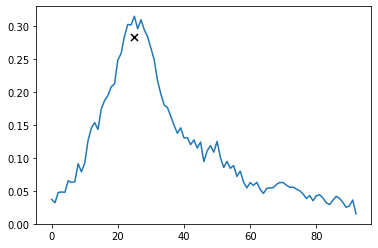

In [ ]:
k = 1
peak_data = find_peaks(targets[k], width=5)
peak_pos, peak_int = peak_data[0][0], peak_data[1]['prominences'][0]
plt.plot(targets[k], zorder=0)
print(peak_pos, peak_int)
plt.scatter(peak_pos, peak_int, marker='x', s=50, c='k', zorder=1)

Same but for all the data:

In [ ]:
peaks_all, features_all, indices_all = [], [], []
for i, t in enumerate(targets):
    peak = find_peaks(t, width=5)[1]["prominences"]
    if len(peak) == 0:
        continue
    peaks_all.append(np.array([peak[0]]) if len(peak) > 1 else peak)
    features_all.append(features[i])
    indices_all.append(indices[i])
peaks_all = np.concatenate(peaks_all)
features_all = np.array(features_all)
indices_all = np.array(indices_all)

Plot the scalarized target values for each feature coordinate:

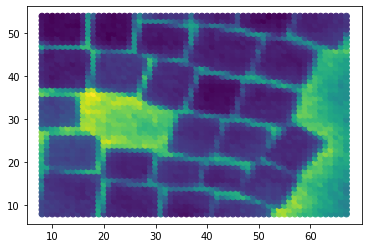

In [ ]:
plt.scatter(indices_all[:, 1], indices_all[:, 0], c=peaks_all)

## DKL on full data

Prepare data for training:

In [ ]:
n, d1, d2 = features_all.shape
X = features_all.reshape(n, d1*d2)
y = peaks_all
X.shape, y.shape

((2820, 256), (2820,))

Train:

In [ ]:
data_dim = X.shape[-1]

key1, key2 = gpax.utils.get_keys()

dkl = gpax.viDKL(data_dim, z_dim=2, kernel='RBF')
dkl.fit(key1, X, y, num_steps=100, step_size=0.05)

100%|██████████| 100/100 [00:53<00:00,  1.86it/s, init loss: 2464.7796, avg. loss [96-100]: -3725.7425]



Inferred parameters
k_length         [10.3727 16.6085]
k_scale          0.1333
noise            0.0073


Make a "prediction" on the training data (since we used all the data for training, our training and test datasets are the same, that is, we basically look at how well our model was able to "fit" the data):

In [ ]:
y_pred, y_sampled = dkl.predict(key2, X, n=10000)
mean, var = y_sampled.mean(0), y_sampled.var(0)

Text(0.5, 1.0, 'DKL uncertainty')

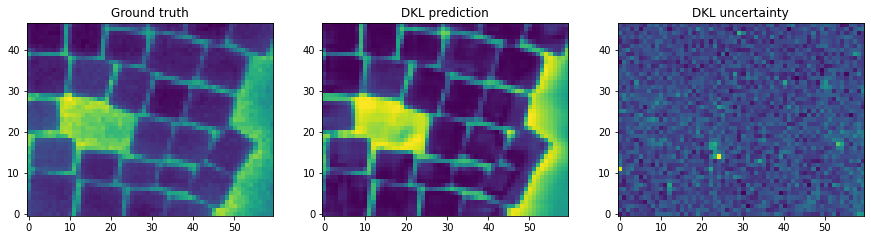

In [ ]:
s1, s2 = img.shape[0] - window_size+1, img.shape[1] - window_size+1

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4.5))
ax1.imshow(peaks_all.reshape(s1, s2), origin="lower")
ax1.set_title("Ground truth")
ax2.imshow(mean.reshape(s1, s2))
ax2.set_title("DKL prediction")
ax2.imshow(mean.reshape(s1, s2), origin="lower")
ax3.imshow(var.reshape(s1, s2), origin="lower")
ax3.set_title("DKL uncertainty")

Note that here the uncertainty was computed by sampling from multivariate normal posterior at 'new' inputs using the inferred predictive mean and covariance and calculating variance in the samples. The produced uncertainty estimate appears a bit noisy. We can instead compute variance directly from the predictive covariance matrix:

In [ ]:
mean, cov = dkl.get_mvn_posterior(X)
var = cov.diagonal()

Text(0.5, 1.0, 'DKL uncertainty')

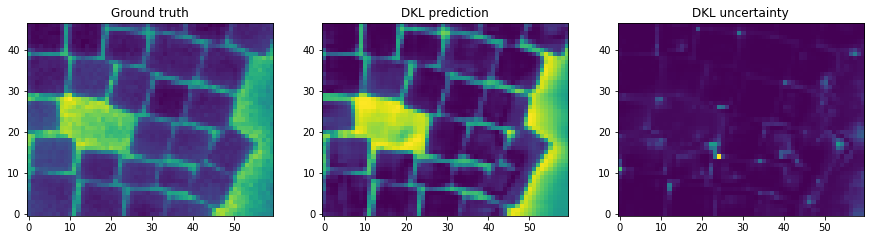

In [ ]:
s1, s2 = img.shape[0] - window_size+1, img.shape[1] - window_size+1

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4.5))
ax1.imshow(peaks_all.reshape(s1, s2), origin="lower")
ax1.set_title("Ground truth")
ax2.imshow(mean.reshape(s1, s2))
ax2.set_title("DKL prediction")
ax2.imshow(mean.reshape(s1, s2), origin="lower")
ax3.imshow(var.reshape(s1, s2), origin="lower")
ax3.set_title("DKL uncertainty")

We can also visualize our latent/embedding space:

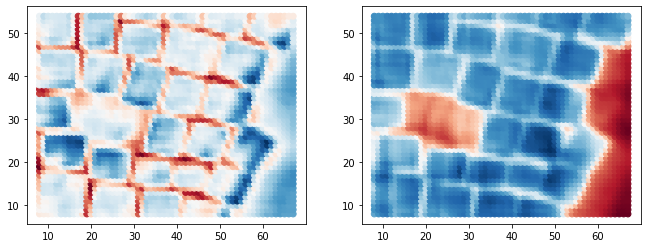

In [ ]:
embeded = dkl.embed(X)
embeded = embeded / embeded.max()

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
ax1.scatter(indices_all[:, 1], indices_all[:, 0], c=embeded[:, 0], cmap='RdBu')
ax2.scatter(indices_all[:, 1], indices_all[:, 0], c=embeded[:, 1], cmap='RdBu')

## DKL on partial data

Now let's use only a part of the data for training:

In [ ]:
split_ = 25
X_train = X[indices_all[:, 1] < split_]
y_train = y[indices_all[:, 1] < split_]
indices_train = indices_all[indices_all[:, 1] < split_]

In [ ]:
data_dim = X.shape[-1]

key1, key2 = gpax.utils.get_keys()

dkl = gpax.viDKL(data_dim, z_dim=2, kernel='RBF')
dkl.fit(key1, X_train, y_train, num_steps=100, step_size=0.05)

100%|██████████| 100/100 [00:04<00:00, 23.17it/s, init loss: 707.5613, avg. loss [96-100]: -1060.8576]


Inferred parameters
k_length         [7.5319 6.945 ]
k_scale          0.2044
noise            0.007200000000000001


In [ ]:
mean, cov = dkl.get_mvn_posterior(X)
var = cov.diagonal()

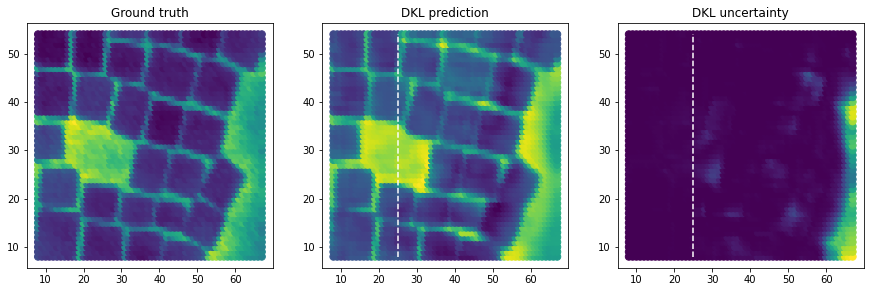

In [ ]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4.5))
ax1.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=peaks_all)
ax1.set_title("Ground truth")
ax2.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=mean)
ax2.set_title("DKL prediction")
ax3.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=var)
ax3.set_title("DKL uncertainty")
ax2.vlines(split_, indices_all[:, 0].min(), indices_all[:, 0].max(), linestyle='--', color='w')
ax3.vlines(split_, indices_all[:, 0].min(), indices_all[:, 0].max(), linestyle='--', color='w')

## Active learning

Here we are going to use DKL for active learning aimed at identifying regions of the sample where a particular behavior (plasmon resonance peak) is maximized. We start with just a few "measured" points:

In [ ]:
n, d1, d2 = features_all.shape
X = features_all.reshape(n, d1*d2)
y = peaks_all
X.shape, y.shape

((2820, 256), (2820,))

In [ ]:
# Here X_train and y_train are our measured image patches (HAADF) and spectra/peaks (EELS),
# whereas X_test and y_test are the "unkwown" ones. The indices_train are grid coordinates of the measured points,
# whereas the indices_test are the grid coordinates of the remaining available points on the grid
(X_train, X_test, y_train, y_test,
  indices_train, indices_test) = train_test_split(
      X, y, indices_all, test_size=0.998, shuffle=True, random_state=4)

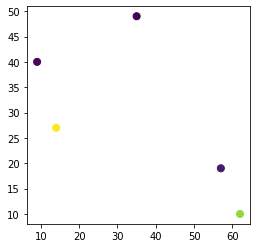

In [ ]:
plt.figure(figsize=(4, 4))
plt.scatter(indices_train[:, 1], indices_train[:, 0], s=50, c=y_train)

Do sample exploration based on the pre-acquired data (i.e., we are running a "dummy" experiment):

1/40


100%|██████████| 100/100 [00:01<00:00, 59.67it/s, init loss: 9.6145, avg. loss [96-100]: 4.2784]



Inferred parameters
k_length         [0.3679 0.3679]
k_scale          0.2942
noise            0.1335


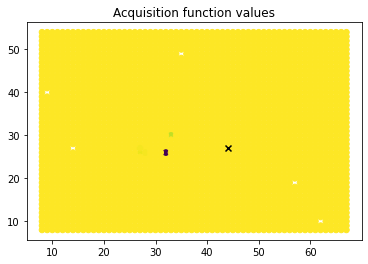

2/40


100%|██████████| 100/100 [00:01<00:00, 56.81it/s, init loss: 10.5558, avg. loss [96-100]: 6.2152]



Inferred parameters
k_length         [0.3679 0.3679]
k_scale          0.18050000000000002
noise            0.1809


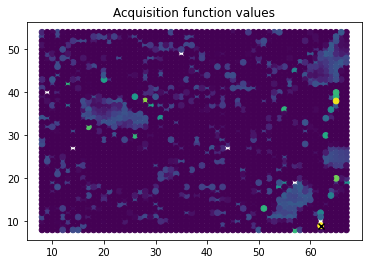

3/40


100%|██████████| 100/100 [00:01<00:00, 55.09it/s, init loss: 11.5331, avg. loss [96-100]: 4.4123]



Inferred parameters
k_length         [0.3679 0.3679]
k_scale          0.2947
noise            0.0994


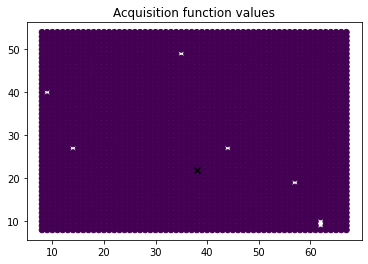

4/40


100%|██████████| 100/100 [00:01<00:00, 55.90it/s, init loss: 12.4540, avg. loss [96-100]: 4.2472]



Inferred parameters
k_length         [0.3679 0.3679]
k_scale          0.2908
noise            0.0858


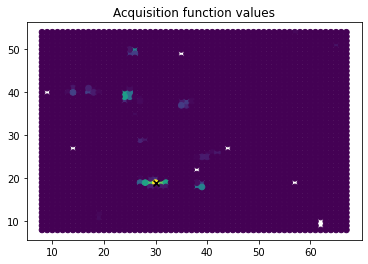

5/40


100%|██████████| 100/100 [00:01<00:00, 59.37it/s, init loss: 13.3692, avg. loss [96-100]: 4.0125]



Inferred parameters
k_length         [0.3679 0.3679]
k_scale          0.2939
noise            0.0747


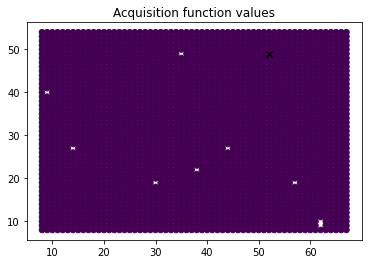

6/40


100%|██████████| 100/100 [00:02<00:00, 48.96it/s, init loss: 14.2710, avg. loss [96-100]: 3.6912]



Inferred parameters
k_length         [0.3679 0.3679]
k_scale          0.29100000000000004
noise            0.0663


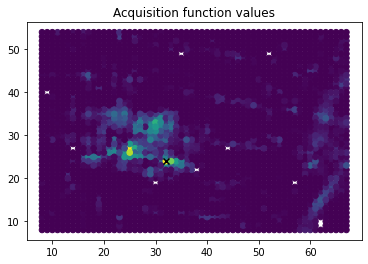

7/40


100%|██████████| 100/100 [00:01<00:00, 58.30it/s, init loss: 15.2527, avg. loss [96-100]: 9.9327]



Inferred parameters
k_length         [0.3679 0.3679]
k_scale          0.15860000000000002
noise            0.1515


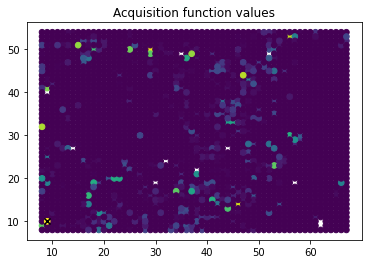

8/40


100%|██████████| 100/100 [00:02<00:00, 44.25it/s, init loss: 16.1524, avg. loss [96-100]: 3.6654]



Inferred parameters
k_length         [0.3679 0.3679]
k_scale          0.29560000000000003
noise            0.0631


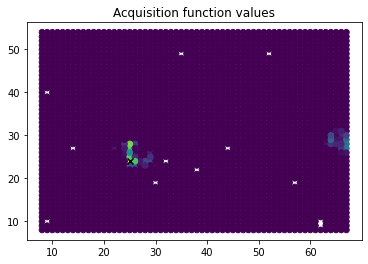

9/40


100%|██████████| 100/100 [00:01<00:00, 55.97it/s, init loss: 17.1301, avg. loss [96-100]: 3.8457]



Inferred parameters
k_length         [0.4983 0.446 ]
k_scale          0.317
noise            0.0199


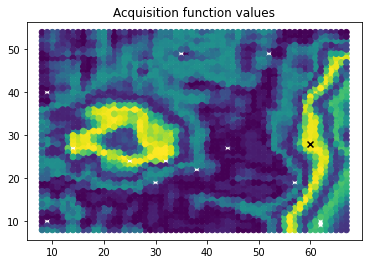

10/40


100%|██████████| 100/100 [00:01<00:00, 51.78it/s, init loss: 18.1060, avg. loss [96-100]: 4.6061]



Inferred parameters
k_length         [0.3679 0.3679]
k_scale          0.3121
noise            0.07100000000000001


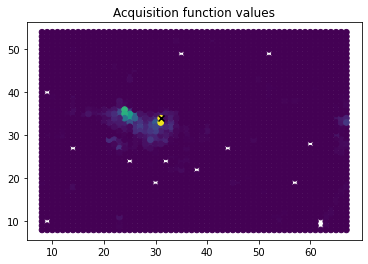

11/40


100%|██████████| 100/100 [00:01<00:00, 53.36it/s, init loss: 19.0195, avg. loss [96-100]: 4.3777]



Inferred parameters
k_length         [0.3726 0.3698]
k_scale          0.3068
noise            0.06670000000000001


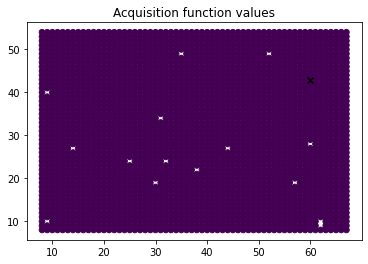

12/40


100%|██████████| 100/100 [00:02<00:00, 49.51it/s, init loss: 19.9291, avg. loss [96-100]: -4.0503]



Inferred parameters
k_length         [0.4973 0.4863]
k_scale          0.3274
noise            0.0145


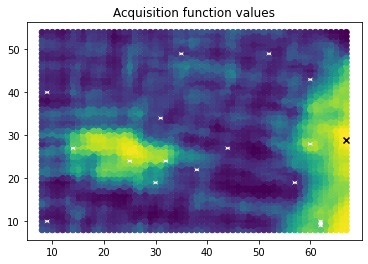

13/40


100%|██████████| 100/100 [00:01<00:00, 52.28it/s, init loss: 20.8435, avg. loss [96-100]: -3.1828]



Inferred parameters
k_length         [0.4104 0.4388]
k_scale          0.2933
noise            0.0158


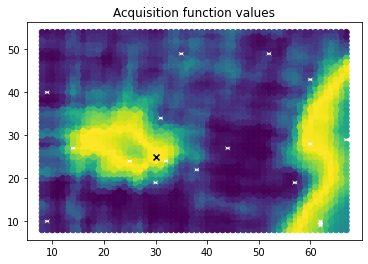

14/40


100%|██████████| 100/100 [00:02<00:00, 48.14it/s, init loss: 21.8107, avg. loss [96-100]: 4.8253]



Inferred parameters
k_length         [0.4451 0.4461]
k_scale          0.2967
noise            0.0485


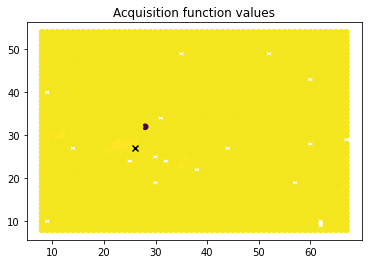

15/40


100%|██████████| 100/100 [00:01<00:00, 51.03it/s, init loss: 22.7428, avg. loss [96-100]: 5.6103]



Inferred parameters
k_length         [0.4103 0.4654]
k_scale          0.3064
noise            0.044700000000000004


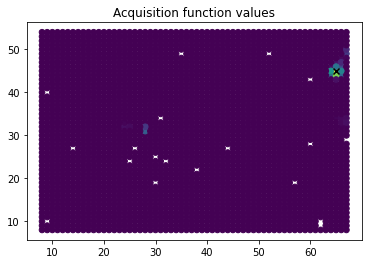

16/40


100%|██████████| 100/100 [00:02<00:00, 45.84it/s, init loss: 23.6523, avg. loss [96-100]: -9.8859]



Inferred parameters
k_length         [0.5108 0.4009]
k_scale          0.3365
noise            0.012400000000000001


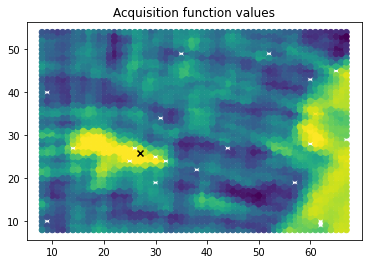

17/40


100%|██████████| 100/100 [00:01<00:00, 51.42it/s, init loss: 24.5915, avg. loss [96-100]: 4.5161]



Inferred parameters
k_length         [0.3679 0.3679]
k_scale          0.3281
noise            0.0639


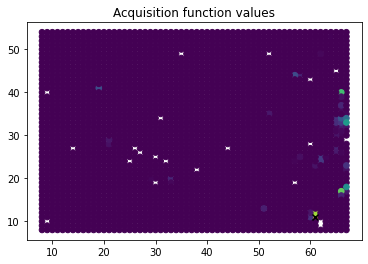

18/40


100%|██████████| 100/100 [00:02<00:00, 46.74it/s, init loss: 25.4999, avg. loss [96-100]: -10.0847]



Inferred parameters
k_length         [0.6398 0.8146]
k_scale          0.2696
noise            0.014400000000000001


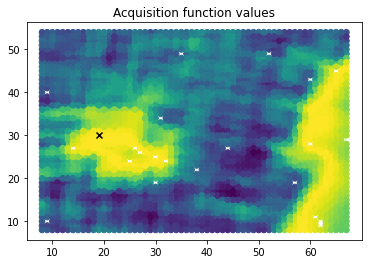

19/40


100%|██████████| 100/100 [00:02<00:00, 49.19it/s, init loss: 26.4180, avg. loss [96-100]: -13.6934]



Inferred parameters
k_length         [0.4714 0.4693]
k_scale          0.3562
noise            0.0111


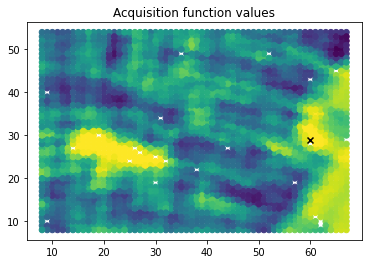

20/40


100%|██████████| 100/100 [00:02<00:00, 44.07it/s, init loss: 27.3501, avg. loss [96-100]: -7.1589]



Inferred parameters
k_length         [0.787  0.6885]
k_scale          0.2733
noise            0.0137


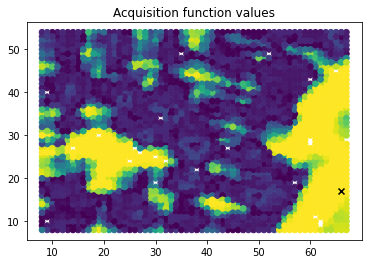

21/40


100%|██████████| 100/100 [00:02<00:00, 46.52it/s, init loss: 28.2451, avg. loss [96-100]: -5.6046]



Inferred parameters
k_length         [0.8446 0.9507]
k_scale          0.26830000000000004
noise            0.015300000000000001


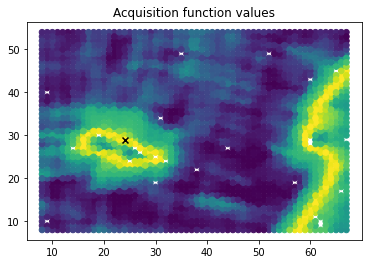

22/40


100%|██████████| 100/100 [00:02<00:00, 38.96it/s, init loss: 29.1551, avg. loss [96-100]: -17.2837]



Inferred parameters
k_length         [0.3698 0.4135]
k_scale          0.40950000000000003
noise            0.0102


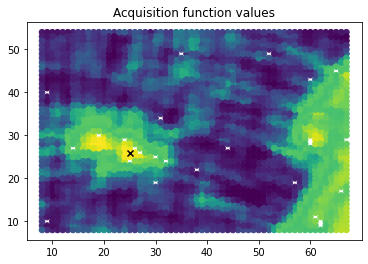

23/40


100%|██████████| 100/100 [00:02<00:00, 45.90it/s, init loss: 30.0485, avg. loss [96-100]: 3.9680]



Inferred parameters
k_length         [0.368 0.368]
k_scale          0.34650000000000003
noise            0.0591


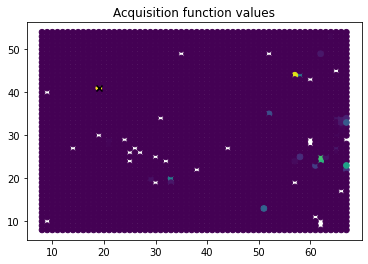

24/40


100%|██████████| 100/100 [00:02<00:00, 38.28it/s, init loss: 30.9489, avg. loss [96-100]: 4.0686]



Inferred parameters
k_length         [0.3679 0.3679]
k_scale          0.3431
noise            0.059500000000000004


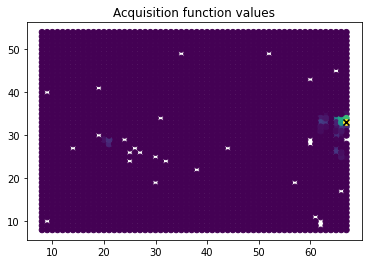

25/40


100%|██████████| 100/100 [00:02<00:00, 43.68it/s, init loss: 31.8386, avg. loss [96-100]: -19.2058]



Inferred parameters
k_length         [0.4209 0.5114]
k_scale          0.27740000000000004
noise            0.0103


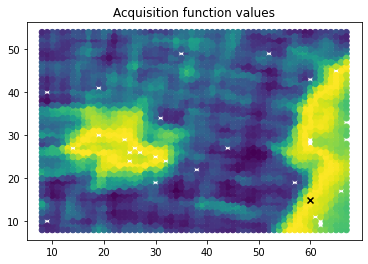

26/40


100%|██████████| 100/100 [00:02<00:00, 40.47it/s, init loss: 32.7167, avg. loss [96-100]: 3.1914]



Inferred parameters
k_length         [0.3681 0.3683]
k_scale          0.3447
noise            0.0557


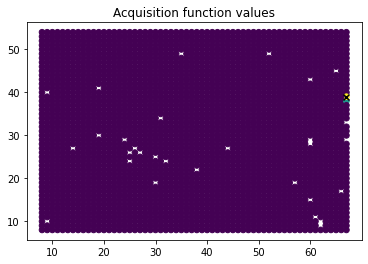

27/40


100%|██████████| 100/100 [00:02<00:00, 38.50it/s, init loss: 33.6056, avg. loss [96-100]: -21.5765]



Inferred parameters
k_length         [0.556  0.4994]
k_scale          0.26930000000000004
noise            0.010400000000000001


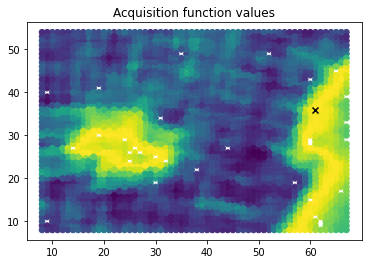

28/40


100%|██████████| 100/100 [00:02<00:00, 48.01it/s, init loss: 34.4833, avg. loss [96-100]: -20.3105]



Inferred parameters
k_length         [0.74   0.7555]
k_scale          0.2691
noise            0.0117


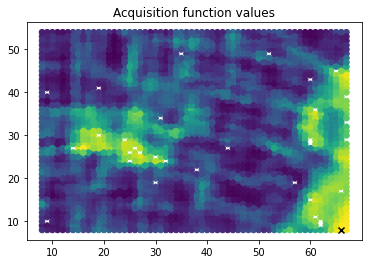

29/40


100%|██████████| 100/100 [00:01<00:00, 51.53it/s, init loss: 35.3742, avg. loss [96-100]: 1.7410]



Inferred parameters
k_length         [0.3679 0.3684]
k_scale          0.3463
noise            0.0509


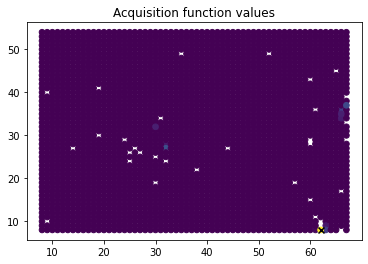

30/40


100%|██████████| 100/100 [00:02<00:00, 48.47it/s, init loss: 36.2601, avg. loss [96-100]: -25.0990]



Inferred parameters
k_length         [0.5608 0.3727]
k_scale          0.27390000000000003
noise            0.0099


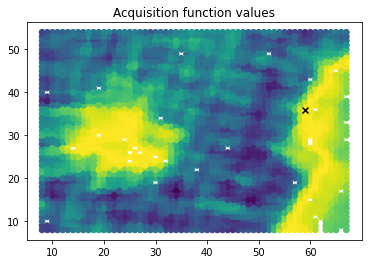

31/40


100%|██████████| 100/100 [00:01<00:00, 51.54it/s, init loss: 37.1586, avg. loss [96-100]: -27.9365]



Inferred parameters
k_length         [0.495  0.6089]
k_scale          0.34450000000000003
noise            0.0094


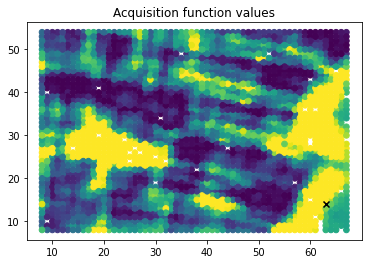

32/40


100%|██████████| 100/100 [00:02<00:00, 48.34it/s, init loss: 38.0305, avg. loss [96-100]: -29.6265]



Inferred parameters
k_length         [0.6234 0.5501]
k_scale          0.26780000000000004
noise            0.0102


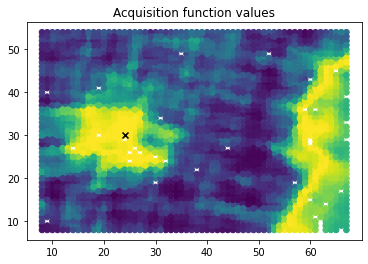

33/40


100%|██████████| 100/100 [00:02<00:00, 43.05it/s, init loss: 38.9288, avg. loss [96-100]: -31.8714]



Inferred parameters
k_length         [0.5214 0.4772]
k_scale          0.2731
noise            0.009000000000000001


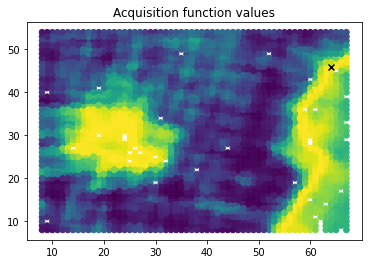

34/40


100%|██████████| 100/100 [00:02<00:00, 44.60it/s, init loss: 39.8127, avg. loss [96-100]: -29.8667]



Inferred parameters
k_length         [0.5992 0.6434]
k_scale          0.2359
noise            0.0094


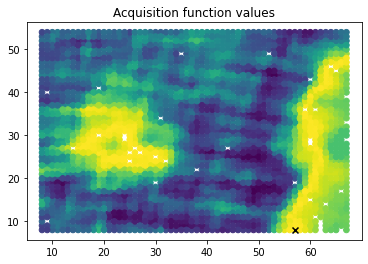

35/40


100%|██████████| 100/100 [00:02<00:00, 49.90it/s, init loss: 40.6990, avg. loss [96-100]: -35.2953]



Inferred parameters
k_length         [0.5241 0.4667]
k_scale          0.2726
noise            0.009000000000000001


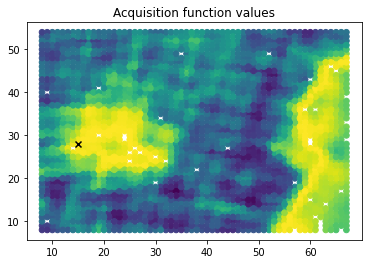

36/40


100%|██████████| 100/100 [00:02<00:00, 45.95it/s, init loss: 41.6083, avg. loss [96-100]: -0.6441]



Inferred parameters
k_length         [0.3682 0.368 ]
k_scale          0.35750000000000004
noise            0.046


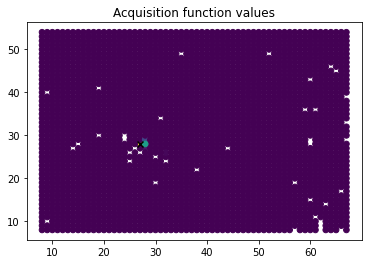

37/40


100%|██████████| 100/100 [00:01<00:00, 50.18it/s, init loss: 42.4816, avg. loss [96-100]: -1.0109]



Inferred parameters
k_length         [0.4496 0.5139]
k_scale          0.3415
noise            0.0425


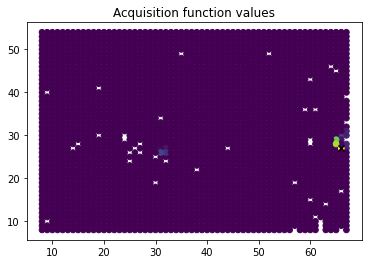

38/40


100%|██████████| 100/100 [00:02<00:00, 39.91it/s, init loss: 43.3524, avg. loss [96-100]: -39.8041]



Inferred parameters
k_length         [0.5345 0.4794]
k_scale          0.268
noise            0.0088


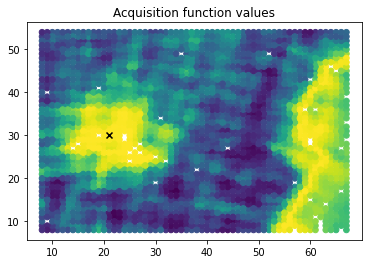

39/40


100%|██████████| 100/100 [00:02<00:00, 49.09it/s, init loss: 44.2441, avg. loss [96-100]: -1.8574]



Inferred parameters
k_length         [0.3683 0.3679]
k_scale          0.3609
noise            0.0442


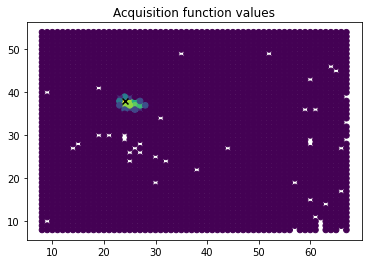

40/40


100%|██████████| 100/100 [00:02<00:00, 44.92it/s, init loss: 45.1579, avg. loss [96-100]: -28.2388]



Inferred parameters
k_length         [0.7085 0.845 ]
k_scale          0.2083
noise            0.009300000000000001


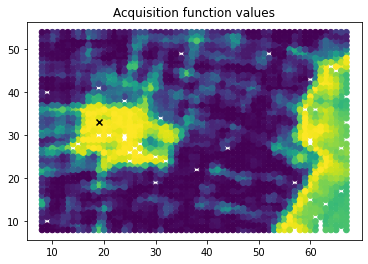

In [ ]:
def plot_result(indices, obj):
    plt.scatter(indices[:, 1], indices[:, 0], s=32, c=obj)
    next_point = indices_test[obj.argmax()]
    plt.scatter(next_point[1], next_point[0], marker='x', c='k')
    plt.title("Acquisition function values")
    plt.show()


data_dim = X_train.shape[-1]

exploration_steps = 40

key1, key2 = gpax.utils.get_keys()
for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))
    # update GP posterior
    dkl = gpax.viDKL(data_dim, 2)
    dkl.fit(key1, X_train, y_train, num_steps=100, step_size=0.05)
    # Compute UCB acquisition function
    obj = gpax.acquisition.UCB(key2, dkl, X_test, maximize=True)
    # Select next point to "measure"
    next_point_idx = obj.argmax()
    next_point = indices_test[next_point_idx]
    # Do "measurement"
    measured_point = y_test[next_point_idx]
    # Plot current result
    plot_result(indices_test, obj)
    # Append to the arrays of measured points
    X_train = np.append(X_train, X_test[next_point_idx][None], 0)
    X_test = np.delete(X_test, next_point_idx, 0)
    y_train = np.append(y_train, measured_point)
    y_test = np.delete(y_test, next_point_idx)
    indices_train = np.append(indices_train, next_point[None], 0)
    indices_test = np.delete(indices_test, next_point_idx, 0)

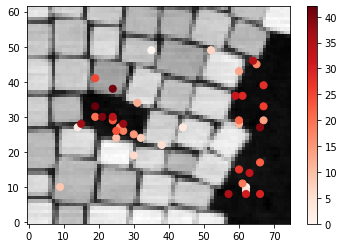

In [ ]:
plt.imshow(img, origin="lower", cmap='gray')
plt.scatter(indices_train[2:, 1], indices_train[2:, 0], c=np.arange(len(indices_train[2:])), s=50, cmap="Reds")
plt.colorbar()

Overlay with a 'ground truth':

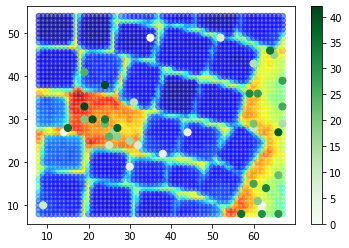

In [ ]:
plt.scatter(indices_all[:, 1], indices_all[:, 0], c=peaks_all, cmap='jet', alpha=0.5)
plt.scatter(indices_train[2:, 1], indices_train[2:, 0], c=np.arange(len(indices_train[2:])), s=50, cmap="Greens")
plt.colorbar()

Looks like it did a pretty good job identifying the regions where a physical behavior of intetest is maximized.